#### Diffusion Models
Important progress was also being made in the field of score-based generative
models,2,3 a branch of energy-based modeling that directly estimates the
gradient of the log distribution (also known as the score function) in order to
train the model, as an alternative to using contrastive divergence. In particular,
Yang Song and Stefano Ermon used multiple scales of noise perturbations

The breakthrough diffusion model paper came in the summer of 2020.4
Standing on the shoulders of earlier works, the paper uncovers a deep
connection between diffusion models and score-based generative models, and
the authors use this fact to train a diffusion model that can rival GANs across
several datasets, called the Denoising Diffusion Probabilistic Model (DDPM).

#### DIFFUSETV
You are standing in an electronics store that sells television sets. However,
this store is clearly very different from ones you have visited in the past.
Instead of a wide variety of different brands, there are hundreds of identical
copies of the same TV connected together in sequence, stretching into the
back of the shop as far as you can see. What’s more, the first few TV sets
appear to be showing nothing but random static noise (Figure 8-1).

The shopkeeper comes over to ask if you need assistance. Confused, you ask
her about the odd setup. She explains that this is the new DiffuseTV model
that is set to revolutionize the entertainment industry and immediately starts
telling you how it works, while walking deeper into the shop, alongside the
line of TVs.

She explains that during the manufacturing process, the DiffuseTV is
exposed to thousands of images of previous TV shows—but each of those
images has been gradually corrupted with random static, until it is
indistinguishable from pure random noise. The TVs are then designed to
undo the random noise, in small steps, essentially trying to predict what the
images looked like before the noise was added. You can see that as you walk
further into the shop the images on each television set are indeed slightly
clearer than the last.

You eventually reach the end of the long line of televisions, where you can
see a perfect picture on the last set. While this is certainly clever technology,
you are curious to understand how this is useful to the viewer. The
shopkeeper continues with her explanation 

Instead of choosing a channel to watch, the viewer chooses a random initial
configuration of static. Every configuration will lead to a different output
image, and in some models can even be guided by a text prompt that you
choose to input. Unlike a normal TV, with a limited range of channels to
watch, the DiffuseTV gives the viewer unlimited choice and freedom to
generate whatever they would like to appear on the screen!
You purchase a DiffuseTV right away and are relieved to hear that the long
line of TVs in the shop is for demonstration purposes only, so you won’t have
to also buy a warehouse to store your new device!

#### Denoising Diffusion Models (DDM)
The core idea behind a denoising diffusion model is simple—we train a deep
learning model to denoise an image over a series of very small steps. If we start
from pure random noise, in theory we should be able to keep applying the
model until we obtain an image that looks as if it were drawn from the training
set. What’s amazing is that this simple concept works so well in practice!


In [ ]:
from tensorflow.keras import utils, layers, callbacks, optimizers,losses, models, metrics, activations
import tensorflow as tf
from utils import sample_batch, display
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
IMAGE_SIZE = 64
BATCH_SIZE = 64
DATASET_REPETITIONS = 5
LOAD_MODEL = False

NOISE_EMBEDDING_SIZE = 32
PLOT_DIFFUSION_STEPS = 20

# optimization
EMA = 0.999
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 50

In [ ]:
flowers = 'C:\\Users\\Whitebox\\Desktop\\envs_and_git_repos\\generative_models\\data\\flowers\\dataset'

In [ ]:
train_data = utils.image_dataset_from_directory(
    flowers,
    labels=None,
    image_size=(64,64),
    batch_size=None,
    shuffle=True,
    seed=42,
    interpolation='bilinear'

)

def preprocess(img):
    img = tf.cast(img,'float32') / 255.0
    return img

train = train_data.map(lambda x: preprocess(x))
train = train.repeat(DATASET_REPETITIONS)
train = train.batch(BATCH_SIZE, drop_remainder=True)

#### The Forward Diffusion Process
Suppose we have an image x0 that we want to corrupt gradually over a large
number of steps (say, T = 1, 000), so that eventually it is indistinguishable from
standard Gaussian noise (i.e., xT should have zero mean and unit variance).
How should we go about doing this?

We can define a function q that adds a small amount of Gaussian noise with
variance βt to an image xt−1 to generate a new image xt. If we keep applying
this function, we will generate a sequence of progressively noisier images (
x0, ..., xT ), as shown in

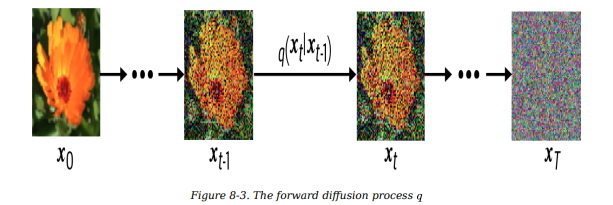

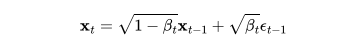

Note that we also scale the input image xt−1, to ensure that the variance of the
output image xt remains constant over time. This way, if we normalize our
original image x0 to have zero mean and unit variance, then xT will
approximate a standard Gaussian distribution for large enough T, by induction,
as follows.



If we assume that xt−1 has zero mean and unit variance then √1 − βtxt−1 will
have variance 1 − βt and √βtϵt−1 will have variance βt, using the rule that
Var (aX) = a2Var(X). Adding these together, we obtain a new distribution xt
with zero mean and variance 1 − βt + βt = 1, using the rule that
Var(X + Y ) = Var(X) + Var(Y ) for independent X and Y . Therefore, if x0 is
normalized to a zero mean and unit variance, then we guarantee that this is also
true for all xt, including the final image xT , which will approximate a standard
Gaussian distribution. This is exactly what we need, as we want to be able to
easily sample xT and then apply a reverse diffusion process through our trained
neural network model!

#### The Reparameterization Trick
It would also be useful to be able to jump straight from an image x0 to any
noised version of the image xt without having to go through t applications of q.
Luckily, there is a reparameterization trick that we can use to do this.

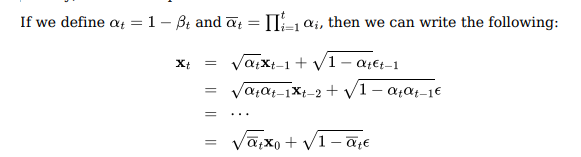

##### Diffusion Schedules
Notice that we are also free to choose a different βt at each timestep—they
don’t all have be the same. How the βt (or αt) values change with t is called the
diffusion schedule

In the original paper (Ho et al., 2020), the authors chose a linear diffusion
schedule for βt—that is, βt increases linearly with t, from β1 = 0.0001 to βT =
0.02. This ensures that in the early stages of the noising process we take
smaller noising steps than in the later stages, when the image is already very
noisy.


In [ ]:
def linear_diffusion_schedule(diffusion_times):
    min_rate = .0001
    max_rate = .02
    betas = min_rate + tf.convert_to_tensor(diffusion_times) * (max_rate - min_rate)
    alphas = 1 - betas
    alpha_bars  = tf.math.cumprod(alphas)
    signal_rates = alpha_bars
    noise_rates = 1 - alpha_bars
    return noise_rates,signal_rates

In a later paper it was found that a cosine diffusion schedule outperformed the
linear schedule from the original paper.5 A cosine schedule defines the
following values of αt

In [ ]:
import math
def cosine_diffusion_schedule(diffusion_times):
    signal_rates = tf.cos(diffusion_times * math.pi/2)
    noise_rates = tf.sin(diffusion_times * math.pi / 2)
    return noise_rates,signal_rates

In [ ]:
def offset_cosine_diffusion_schedule(diffusion_times):
    min_signal_rate = 0.02
    max_signal_rate = 0.95
    start_angle = tf.acos(max_signal_rate)
    end_angle = tf.acos(min_signal_rate)
    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)
    signal_rates = tf.cos(diffusion_angles)
    noise_rates = tf.sin(diffusion_angles)
    return noise_rates, signal_rates


In [ ]:
T = 1000
diffusion_times = tf.convert_to_tensor([x / T for x in range(T)])
linear_noise_rates, linear_signal_rates = linear_diffusion_schedule(
    diffusion_times
)
cosine_noise_rates, cosine_signal_rates = cosine_diffusion_schedule(
    diffusion_times
)
(
    offset_cosine_noise_rates,
    offset_cosine_signal_rates,
) = offset_cosine_diffusion_schedule(diffusion_times)

Notice how the noise level ramps up more slowly in the cosine diffusion
schedule. A cosine diffusion schedule adds noise to the image more gradually
than a linear diffusion schedule, which improves training efficiency and
generation quality. This can also be seen in images that have been corrupted by
the linear and cosine schedules

In [ ]:
plt.plot(
    diffusion_times, linear_signal_rates**2, linewidth=1.5, label="linear"
)
plt.plot(
    diffusion_times, cosine_signal_rates**2, linewidth=1.5, label="cosine"
)
plt.plot(
    diffusion_times,
    offset_cosine_signal_rates**2,
    linewidth=1.5,
    label="offset_cosine",
)

plt.xlabel("t/T", fontsize=12)
plt.ylabel(r"$\bar{\alpha_t}$ (signal)", fontsize=12)
plt.legend()
plt.show()

In [ ]:
plt.plot(
    diffusion_times, linear_noise_rates**2, linewidth=1.5, label="linear"
)
plt.plot(
    diffusion_times, cosine_noise_rates**2, linewidth=1.5, label="cosine"
)
plt.plot(
    diffusion_times,
    offset_cosine_noise_rates**2,
    linewidth=1.5,
    label="offset_cosine",
)

plt.xlabel("t/T", fontsize=12)
plt.ylabel(r"$1-\bar{\alpha_t}$ (noise)", fontsize=12)
plt.legend()
plt.show()

In [ ]:
def sinusoidal_embedding(x):
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(1.0),
            tf.math.log(1000.0),
            NOISE_EMBEDDING_SIZE // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    )
    return embeddings

#### The Reverse Diffusion Process
Now let’s look at the reverse diffusion process. To recap, we are looking to
build a neural network pθ (xt−1|xt) that can undo the noising process—that is,
approximate the reverse distribution q(xt−1|xt). If we can do this, we can
sample random noise from N (0, I) and then apply the reverse diffusion process
multiple times in order to generate a novel image.

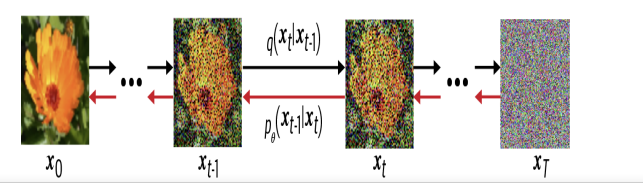

There are many similarities between the reverse diffusion process and the
decoder of a variational autoencoder. In both, we aim to transform random
noise into meaningful output using a neural network. The difference between
diffusion models and VAEs is that in a VAE the forward process (converting
images to noise) is part of the model (i.e., it is learned), whereas in a diffusion
model it is unparameterized

Therefore, it makes sense to apply the same loss function as in a variational
autoencoder. The original DDPM paper derives the exact form of this loss
function and shows that it can be optimized by training a network ϵθ to predict
the noise ϵ that has been added to a given image x0 at timestep t.

In other words, we sample an image x0 and transform it by t noising steps to
get the image xt = √αtx0 + √1 − αtϵ. We give this new image and the noising
rate αt to the neural network and ask it to predict ϵ, taking a gradient step
against the squared error between the prediction ϵθ (xt) and the true ϵ.


We'll take a look at the structure of the neural network in the next section. It is
worth noting here that the diffusion model actually maintains two copies of the
network: one that is actively trained used gradient descent and another (the
EMA network) that is an exponential moving average (EMA) of the weights of
the actively trained network over previous training steps. The EMA network is
not as susceptible to short-term fluctuations and spikes in the training process, making it more robust for generation than the actively trained network. We
therefore use the EMA network whenever we want to produce generated output
¯
¯
from the network

In [ ]:
embedding_list = []
for y in np.arange(0, 1, 0.01):
    embedding_list.append(sinusoidal_embedding(np.array([[[[y]]]]))[0][0][0])
embedding_array = np.array(np.transpose(embedding_list))
fig, ax = plt.subplots()
ax.set_xticks(
    np.arange(0, 100, 10), labels=np.round(np.arange(0.0, 1.0, 0.1), 1)
)
ax.set_ylabel("embedding dimension", fontsize=8)
ax.set_xlabel("noise variance", fontsize=8)
plt.pcolor(embedding_array, cmap="coolwarm")
plt.colorbar(orientation="horizontal", label="embedding value")
ax.imshow(embedding_array, interpolation="nearest", origin="lower")
plt.show()

In [48]:
def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=activations.swish)(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply

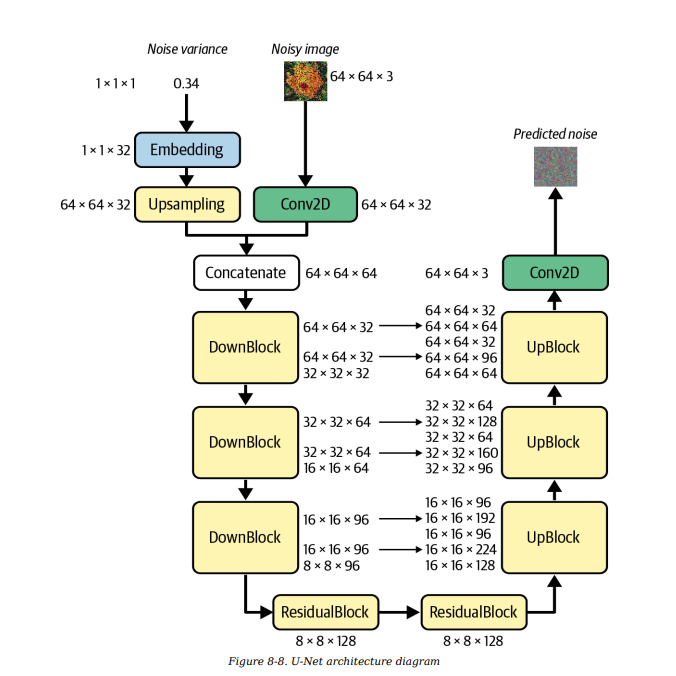

In [51]:
# Build the U-Net

noisy_images = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = layers.Conv2D(32, kernel_size=1)(noisy_images)

noise_variances = layers.Input(shape=(1, 1, 1))
noise_embedding = layers.Lambda(sinusoidal_embedding)(noise_variances)
noise_embedding = layers.UpSampling2D(size=IMAGE_SIZE, interpolation="nearest")(
    noise_embedding
)

x = layers.Concatenate()([x, noise_embedding])

skips = []

x = DownBlock(32, block_depth=2)([x, skips])

x = DownBlock(64, block_depth=2)([x, skips])
x = DownBlock(96, block_depth=2)([x, skips])

x = ResidualBlock(128)(x)
x = ResidualBlock(128)(x)

x = UpBlock(96, block_depth=2)([x, skips])
x = UpBlock(64, block_depth=2)([x, skips])
x = UpBlock(32, block_depth=2)([x, skips])

x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

unet = models.Model([noisy_images, noise_variances], x, name="unet")

In [50]:
# Exploring dimensions for Unet
# noises = tf.random.normal(shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3))

# diffusion_times = tf.random.uniform(
#     shape=(BATCH_SIZE, 1, 1, 1), minval=0.0, maxval=1.0
# )
# noise_rates, signal_rates = ddm.diffusion_schedule(diffusion_times)
# noisy_images = signal_rates * train_sample + noise_rates * noises
# op = unet([noisy_images, noise_rates**2], training=True)
# op.shape,skips[0].shape,skips[1].shape

(TensorShape([64, 32, 32, 32]),
 TensorShape([None, 64, 64, 32]),
 TensorShape([None, 64, 64, 32]))

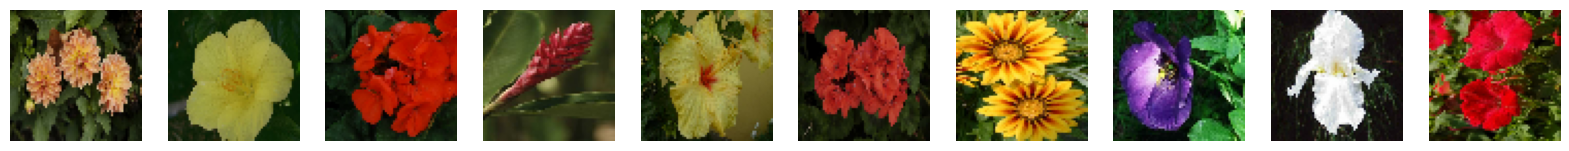

In [19]:
train_sample = sample_batch(train)
display(train_sample)

<tf.Tensor: shape=(64, 32, 32, 32), dtype=float32, numpy=
array([[[[-1.52605391e+00,  2.06281021e-01, -1.23620200e+00, ...,
           2.70657212e-01,  9.09003258e-01,  1.04116070e+00],
         [-1.60075021e+00,  2.39759102e-01, -1.03499901e+00, ...,
           1.10130832e-01,  8.50698888e-01,  1.14270949e+00],
         [-1.56047094e+00, -3.72932285e-01, -1.01704478e+00, ...,
           4.98960525e-01,  9.90985394e-01,  1.06672120e+00],
         ...,
         [-1.72781563e+00,  4.89913411e-02, -1.15868652e+00, ...,
           1.57135233e-01,  1.33369875e+00,  1.14521694e+00],
         [-1.80636513e+00,  3.78265321e-01, -5.30163109e-01, ...,
           2.40211263e-02,  5.60100675e-01,  1.18024957e+00],
         [-7.10231662e-01,  6.78586721e-01, -5.48622370e-01, ...,
           5.42182982e-01,  5.64158916e-01,  1.19607198e+00]],

        [[-2.47624636e+00, -2.26197809e-01, -1.12862217e+00, ...,
           7.26662278e-02,  1.02604365e+00,  1.28641593e+00],
         [-1.42882347e+00, -2.

<tf.Tensor: shape=(64, 64, 64, 3), dtype=float32, numpy=
array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


   

In [ ]:
class DiffusionModel(models.Model):
    def __init__(self):
        super().__init__()

        self.normalizer = layers.Normalization()
        self.network = unet
        self.ema_network = models.clone_model(self.network)
        self.diffusion_schedule = offset_cosine_diffusion_schedule

    def compile(self, **kwargs):
        super().compile(**kwargs)
        self.noise_loss_tracker = metrics.Mean(name="n_loss")

    @property
    def metrics(self):
        return [self.noise_loss_tracker]

    def denormalize(self, images):
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return tf.clip_by_value(images, 0.0, 1.0)

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        if training:
            network = self.network
        else:
            network = self.ema_network
        pred_noises = network(
            [noisy_images, noise_rates**2], training=training
        )
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps
        current_images = initial_noise
        for step in range(diffusion_steps):
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                current_images, noise_rates, signal_rates, training=False
            )
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            current_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
        return pred_images

    def generate(self, num_images, diffusion_steps, initial_noise=None):
        if initial_noise is None:
            initial_noise = tf.random.normal(
                shape=(num_images, IMAGE_SIZE, IMAGE_SIZE, 3)
            )
        generated_images = self.reverse_diffusion(
            initial_noise, diffusion_steps
        )
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, images):
        images = self.normalizer(images, training=True)
        noises = tf.random.normal(shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3))

        diffusion_times = tf.random.uniform(
            shape=(BATCH_SIZE, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)

        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # used for training

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(
            zip(gradients, self.network.trainable_weights)
        )

        self.noise_loss_tracker.update_state(noise_loss)

        for weight, ema_weight in zip(
            self.network.weights, self.ema_network.weights
        ):
            ema_weight.assign(EMA * ema_weight + (1 - EMA) * weight)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, images):
        images = self.normalizer(images, training=False)
        noises = tf.random.normal(shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3))
        diffusion_times = tf.random.uniform(
            shape=(BATCH_SIZE, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        noisy_images = signal_rates * images + noise_rates * noises
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, training=False
        )
        noise_loss = self.loss(noises, pred_noises)
        self.noise_loss_tracker.update_state(noise_loss)

        return {m.name: m.result() for m in self.metrics}

In [ ]:
ddm = DiffusionModel()
ddm.normalizer.adapt(train)

In [ ]:
ddm.compile(
    optimizer=optimizers.experimental.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    ),
    loss=losses.mean_absolute_error,
)

In [ ]:
# run training and plot generated images periodically
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [ ]:
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generate(
            num_images=self.num_img,
            diffusion_steps=PLOT_DIFFUSION_STEPS,
        ).numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )


image_generator_callback = ImageGenerator(num_img=10)

ddm.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        image_generator_callback,
    ],
)

#### Inference

In [ ]:
# Generate some novel images of flowers
generated_images = ddm.generate(num_images=10, diffusion_steps=20).numpy()
display(generated_images)

In [ ]:
# View improvement over greater number of diffusion steps
for diffusion_steps in list(np.arange(1, 6, 1)) + [20] + [100]:
    tf.random.set_seed(42)
    generated_images = ddm.generate(
        num_images=10,
        diffusion_steps=diffusion_steps,
    ).numpy()
    display(generated_images)